In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set(font_scale=2)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, classification_report, confusion_matrix)
from sklearn.metrics import roc_auc_score, roc_curve
from yellowbrick.classifier import (DiscriminationThreshold,
PrecisionRecallCurve)
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import shap

In [4]:
data = pd.read_csv('Bank_C_Prediction.csv')
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
display(data.describe())
display(data.describe(include='object'))


,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,country,gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [6]:
data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [7]:
data['customer_id'].value_counts(ascending=False)

customer_id
15634602    1
15667932    1
15766185    1
15667632    1
15599024    1
           ..
15599078    1
15702300    1
15660735    1
15671390    1
15628319    1
Name: count, Length: 10000, dtype: int64

In [8]:
id_column = 'customerId'
#separation to categorical and numerical features
target_column = ['churn']
categorical_features = ['country', 'gender', 'credit_card', 'active_member']
numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']

# Remove from numerical if present
if id_column in numerical_features:
    numerical_features.remove(id_column)
if target_column in numerical_features:
    numerical_features.remove(target_column)

# Remove from categorical if present
if id_column in categorical_features:
    categorical_features.remove(id_column)
if target_column in categorical_features:
    categorical_features.remove(target_column)

In [9]:
X = data.drop(target_column, axis=1)
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#validation
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 11), (2000, 11), (8000,), (2000,))

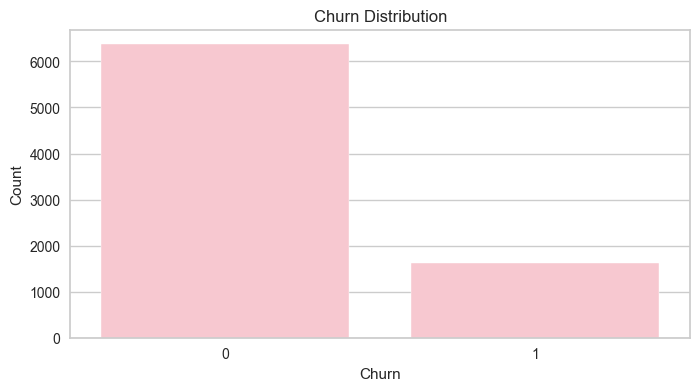

churn
0    0.79625
1    0.20375
Name: proportion, dtype: float64

In [10]:
f = plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, color='pink')  # Use x= instead of y=
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')

plt.show()

# Show proportions
display(y_train.value_counts(normalize=True))


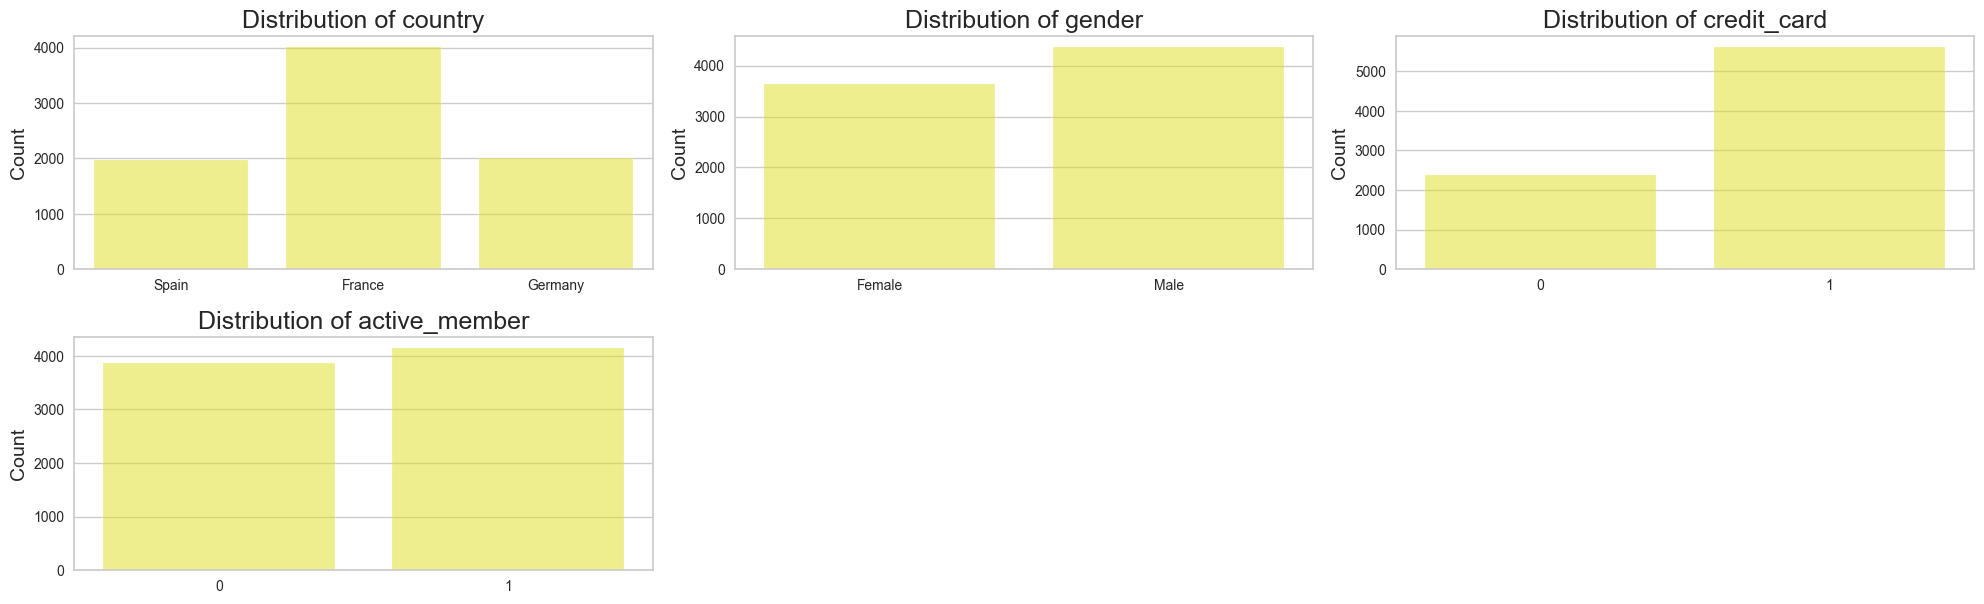

In [11]:
# Plotting the distributions of the categorical variables
f = plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_features):
    plt.subplot(5, 3, i + 1)
    
    unique_vals = X_train[col].nunique()
    
    if unique_vals <= 5:
        sns.countplot(data=X_train, x=col, color='yellow', alpha=0.5)
        plt.xlabel("")
        plt.ylabel("Count", fontsize=14)
    else:
        sns.countplot(data=X_train, y=col, order=X_train[col].value_counts().index, color='darkred', alpha=0.5)
        plt.ylabel("")
    
    plt.title(f"Distribution of {col}", fontsize=18)

plt.tight_layout()
plt.savefig("Categorical_distributions.png")
plt.show()

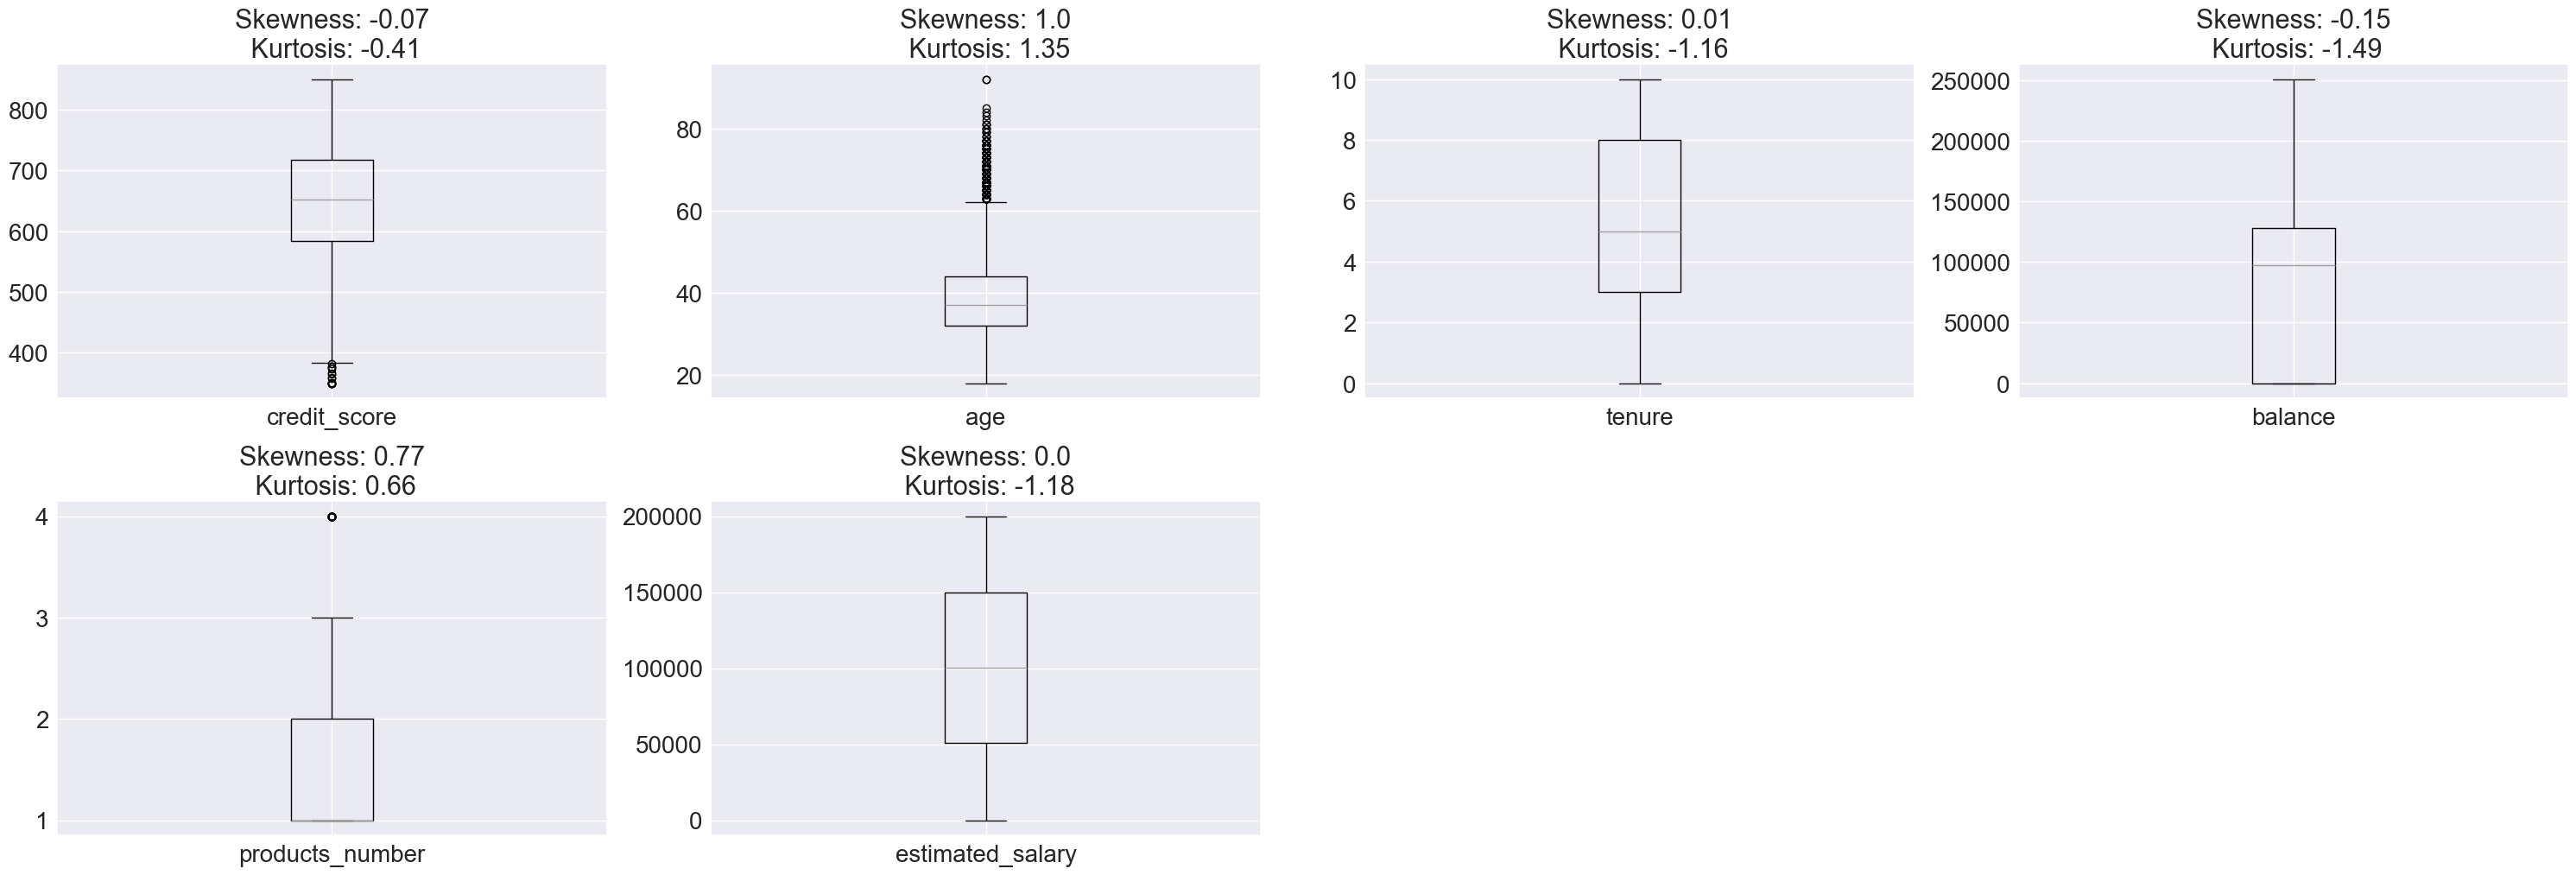

In [12]:
#plotting the distributions of the numerical variables
sns.set_style("darkgrid")
plt.figure(figsize=(30,15))
for i,col in enumerate(numerical_features):
    plt.subplot(3,4,i+1)
    X_train[[col]].boxplot(fontsize=20)
    plt.title(f'Skewness: {np.round(X_train[col].skew(),2)}\n Kurtosis: {np.round(X_train[col].kurt(),2)}',
              fontdict={'fontsize':22})
    plt.savefig("cont variables")
    plt.tight_layout();

In [13]:
#skewness should be between -1 to 1. Age is more skewed towards older people

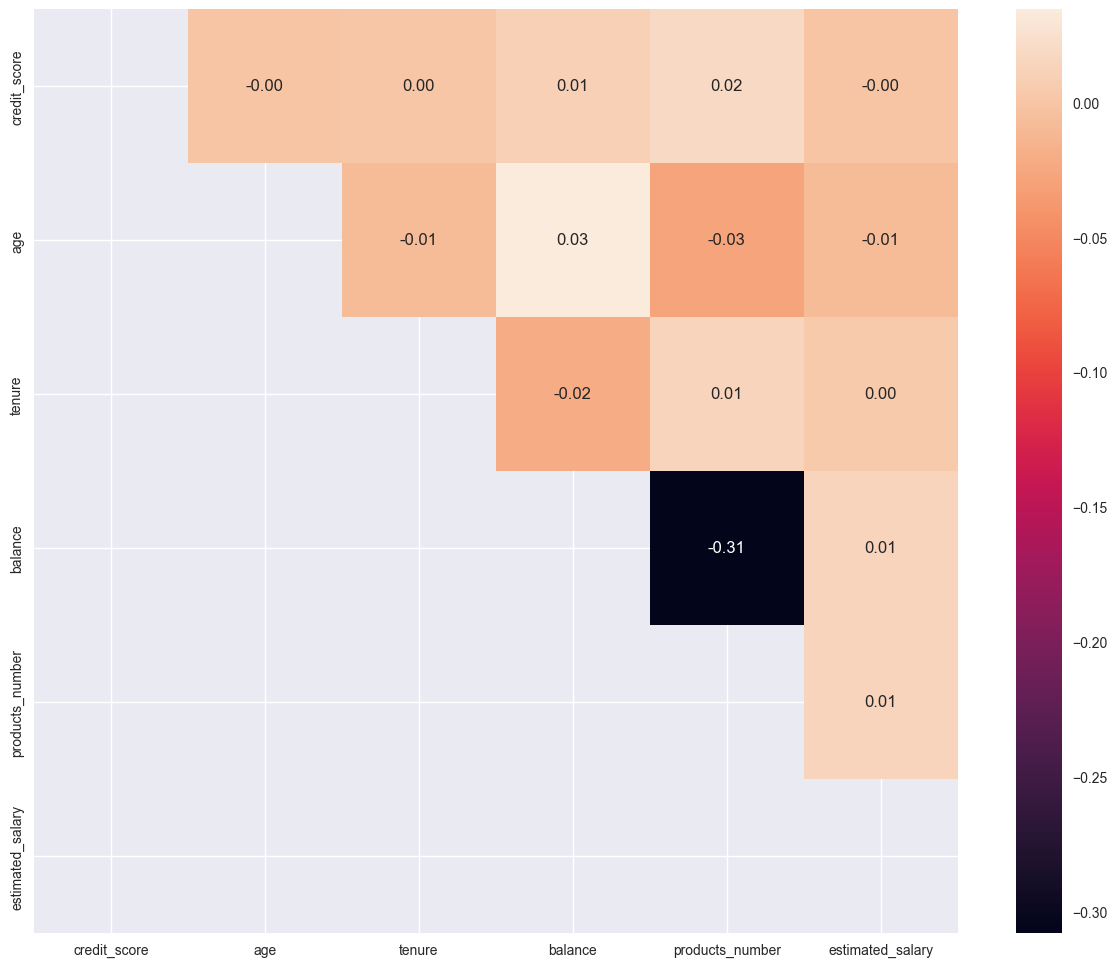

In [14]:
#correlation matrix
corr = X_train[numerical_features].corr()

plt.figure(figsize=(15,12))
mask = np.tril(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt=".2f", mask = mask, square = True)
plt.show()

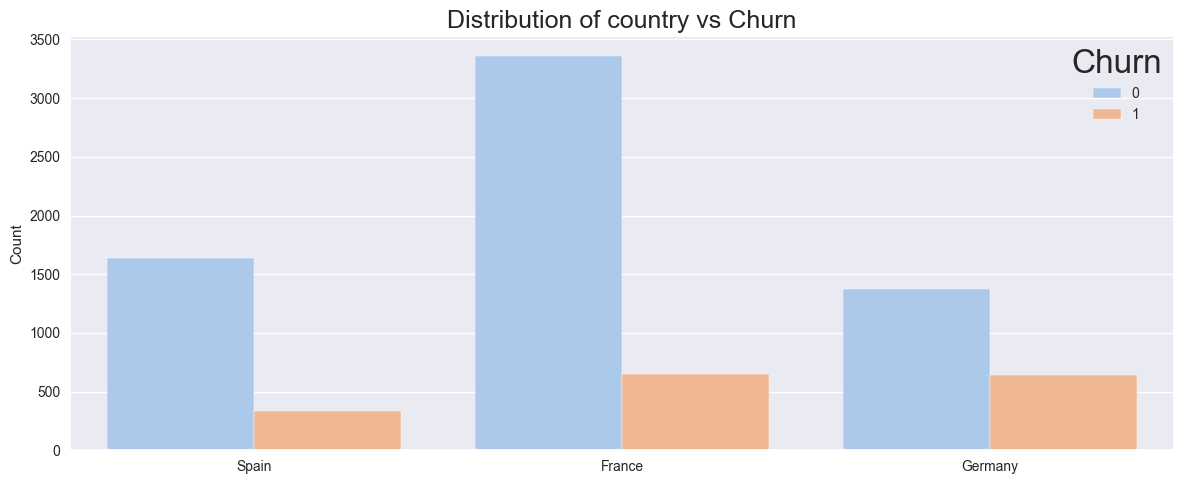

Overall frequency:


country
France     0.501250
Germany    0.251625
Spain      0.247125
Name: proportion, dtype: float64

**************************************************


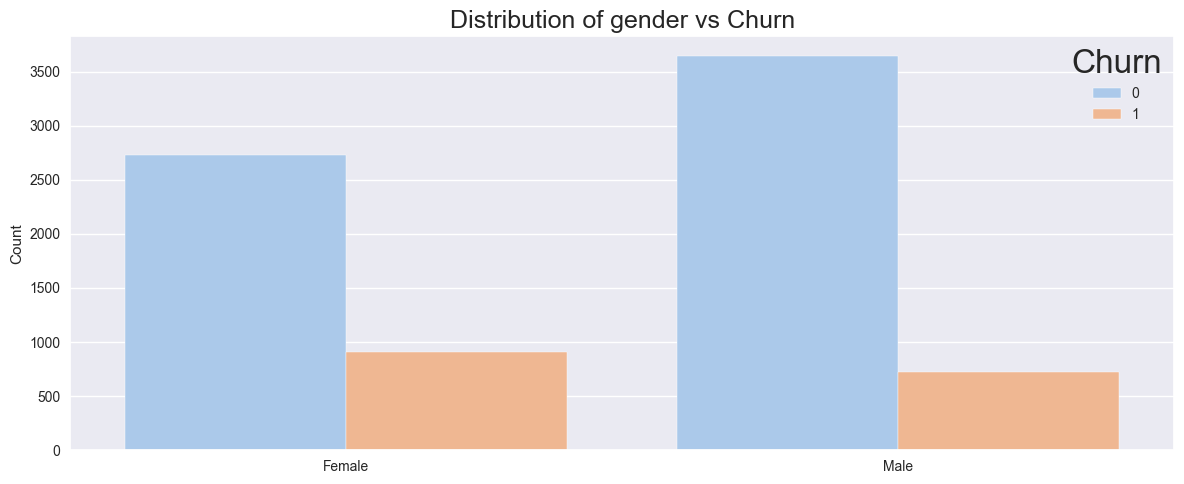

Overall frequency:


gender
Male      0.5455
Female    0.4545
Name: proportion, dtype: float64

**************************************************


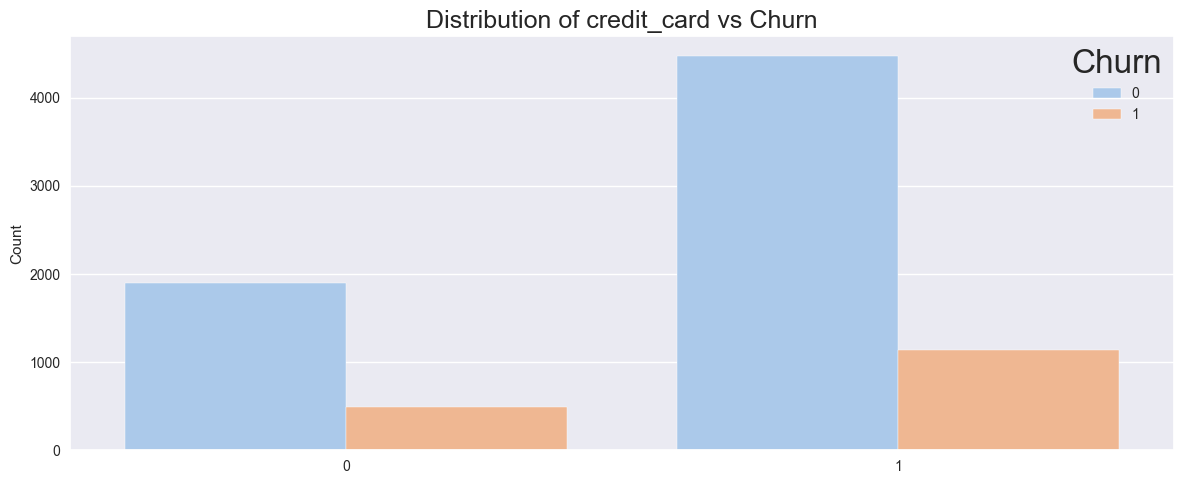

Overall frequency:


credit_card
1    0.7015
0    0.2985
Name: proportion, dtype: float64

**************************************************


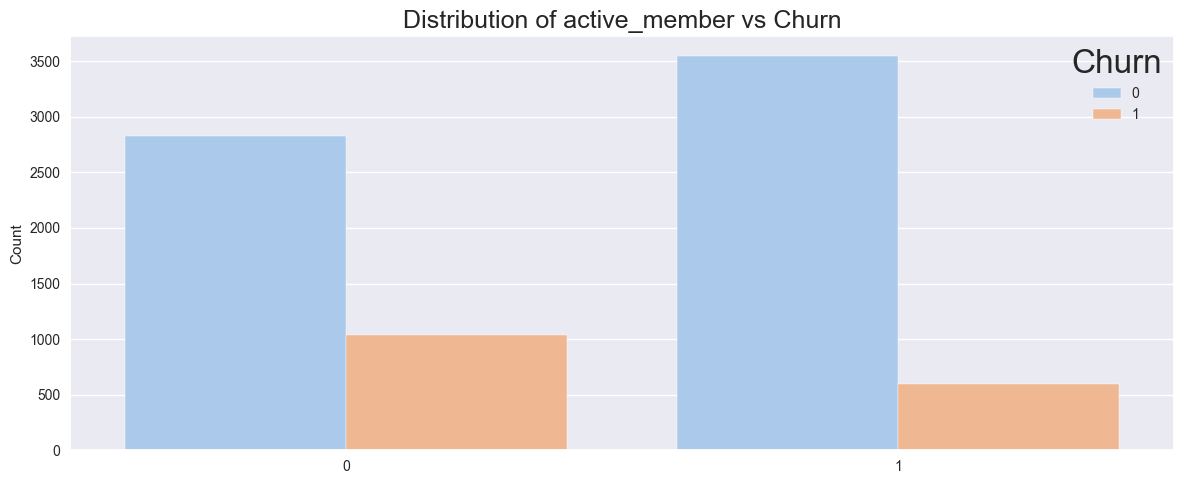

Overall frequency:


active_member
1    0.5175
0    0.4825
Name: proportion, dtype: float64

**************************************************


In [15]:
# Combine X and y into a single DataFrame
df_train = pd.concat([X_train.copy(), y_train.copy()], axis=1)
df_train.rename(columns={df_train.columns[-1]: 'churn'}, inplace=True)  # rename the target column to 'churn'

for col in categorical_features:
    if col in df_train.columns:
        plt.figure(figsize=(12, 5))

        if df_train[col].nunique() < 4:
            sns.countplot(data=df_train, x=col, hue='churn', palette='pastel')
        else:
            sns.countplot(data=df_train, y=col, hue='churn', order=df_train[col].value_counts().index, palette='pastel')

        plt.title(f"Distribution of {col} vs Churn", fontsize=18)
        plt.xlabel("")
        plt.ylabel("Count")
        plt.legend(title='Churn')
        plt.tight_layout()
        plt.show()

        print('Overall frequency:')
        display(df_train[col].value_counts(normalize=True))
        print()

        # Odds ratio calculation
        odds_dict = {}
        for unique_val in df_train[col].unique():
            churned = df_train[(df_train['churn'] == 1) & (df_train[col] == unique_val)].shape[0]
            not_churned = df_train[(df_train['churn'] == 0) & (df_train[col] == unique_val)].shape[0]

            if not_churned == 0:
                odds = float('inf')  # avoid division by zero
            else:
                odds = round((churned / not_churned) * 100, 2)

            odds_dict[unique_val] = odds

        odds_df = pd.Series(odds_dict, name=f'{col}_odds_ratio - Churn/Not Churn (%)').reset_index() \
            .rename(columns={'index': 'Categories'})

        # Plot interactive odds ratio table using Plotly
        fig = go.Figure(data=[go.Table(
            header=dict(values=list(odds_df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[odds_df[val] for val in odds_df.columns],
                       fill_color='lavender',
                       align='left'))
        ])
        fig.update_layout(autosize=False)
        fig.show()

        print('*' * 50)


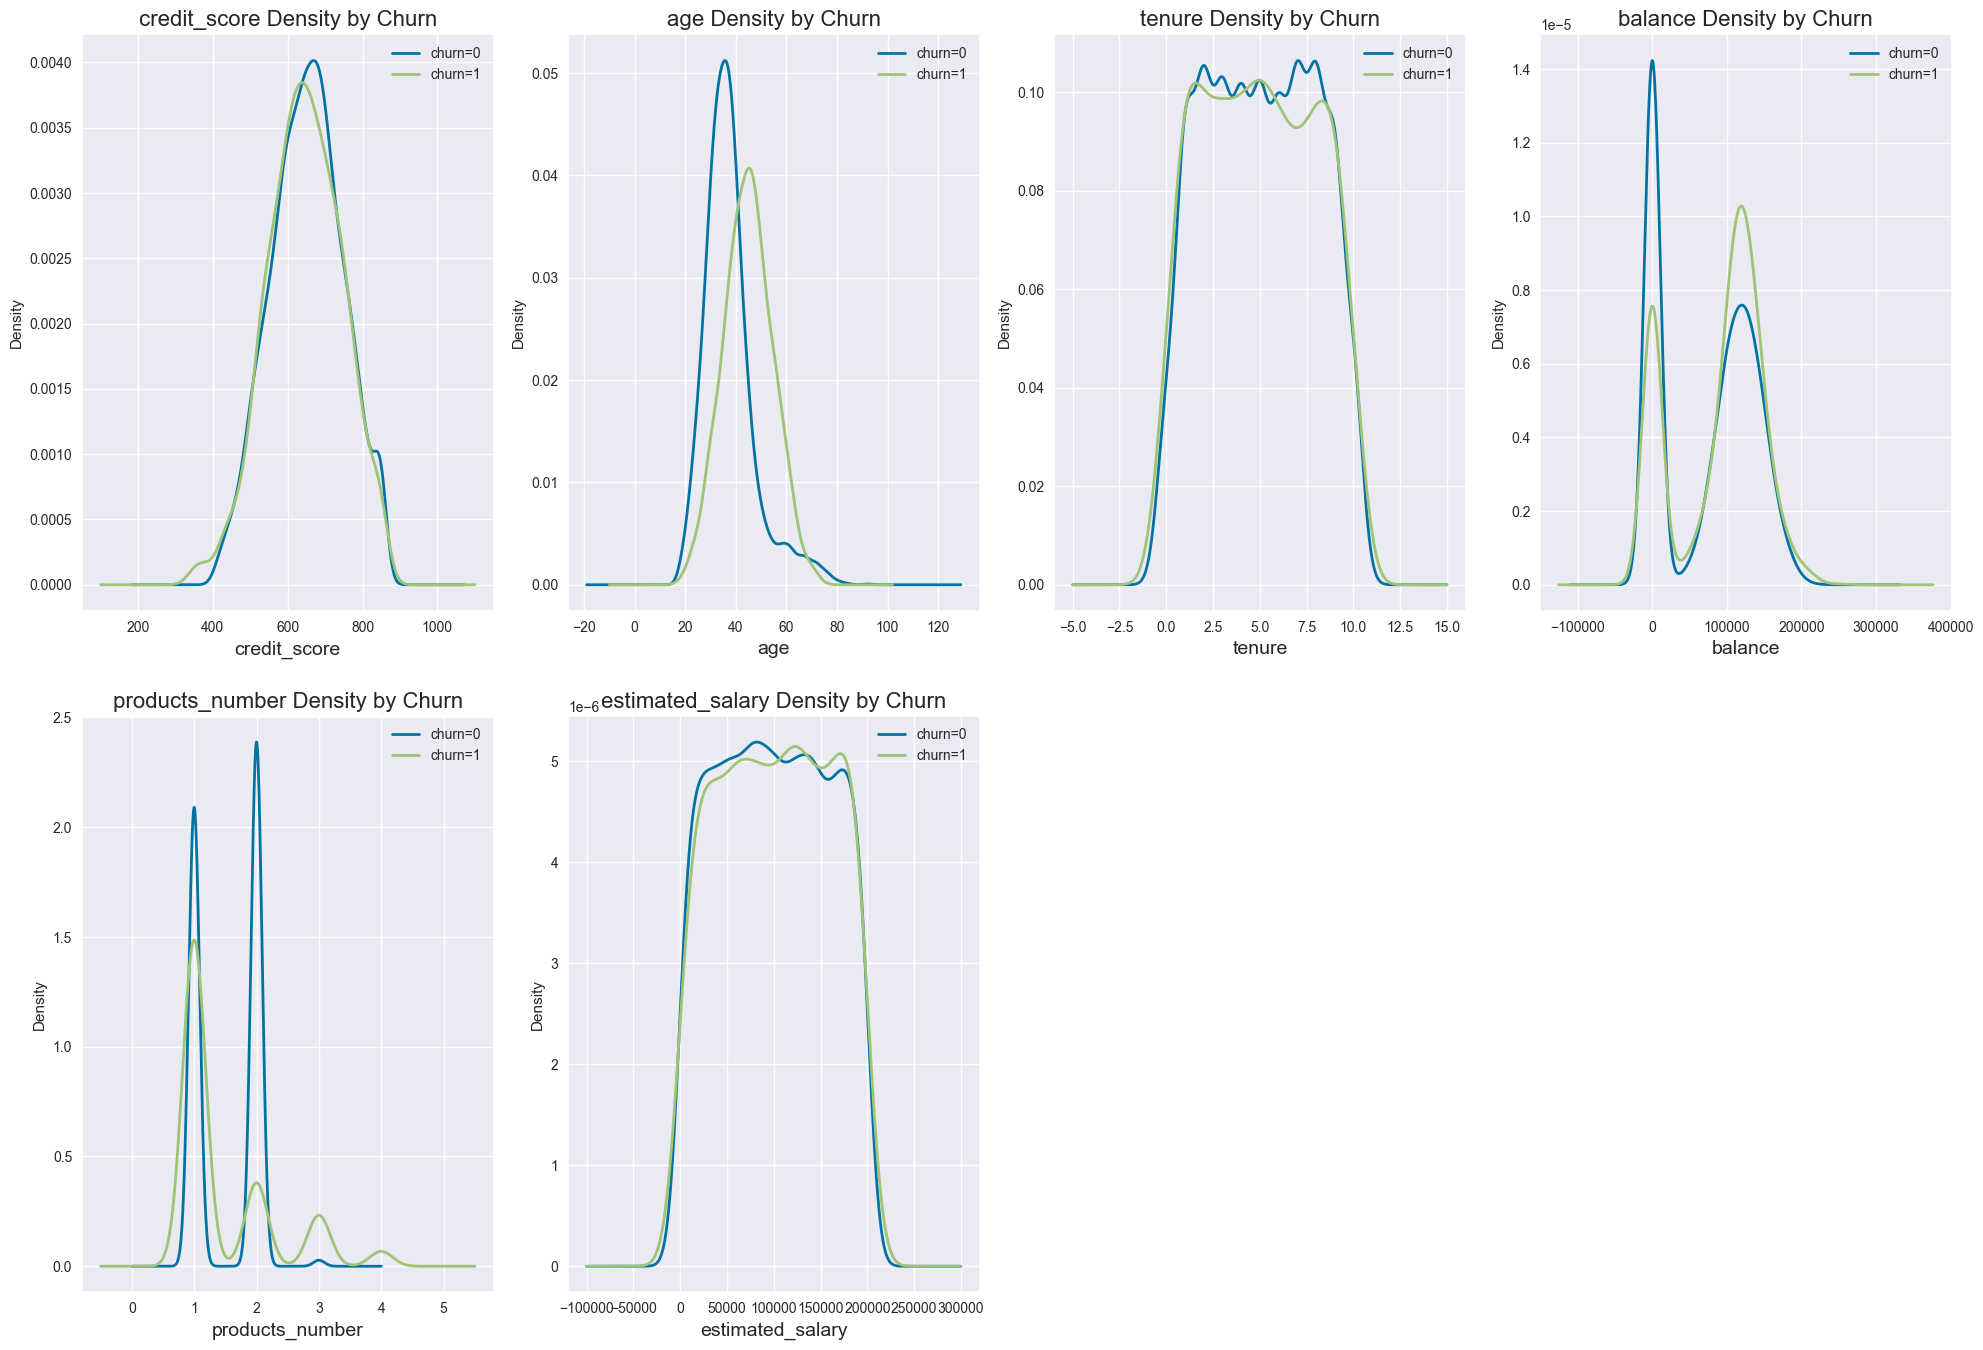

In [16]:
# Combine features and target into one DataFrame
df_train = pd.concat([X_train.copy(), y_train.copy()], axis=1)
df_train.rename(columns={df_train.columns[-1]: 'churn'}, inplace=True)  # ensure target column is 'churn'

# Set up the figure
plt.figure(figsize=(20, 20))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)

    # Plot KDE for each class of churn
    for churn_val in sorted(df_train['churn'].unique()):
        subset = df_train[df_train['churn'] == churn_val]
        subset[col].plot(kind='kde', label=f'churn={churn_val}', linewidth=2)

    plt.title(f'{col} Density by Churn', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.legend()

plt.tight_layout()
plt.savefig("numerical_vs_churn.png")
plt.show()


In [17]:
#relevant categorical features
nominal_categorical_features = ['gender', 'country']

In [18]:
# Create and fit the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply one-hot encoding to nominal features
nominal_mat = encoder.fit_transform(X_train[nominal_categorical_features])

# Create a DataFrame from the encoded matrix
nominal_df = pd.DataFrame(nominal_mat,
                          columns=encoder.get_feature_names_out(nominal_categorical_features),
                          index=X_train.index)

# Drop original nominal columns
X_train = X_train.drop(columns=nominal_categorical_features)

# Concatenate the encoded features back to the dataset
X_train = pd.concat([X_train, nominal_df], axis=1)


In [19]:
# Transform nominal features in the test set using the same encoder fitted on training data
nominal_mat_test = encoder.transform(X_test[nominal_categorical_features])

# Create DataFrame with same column names as training encoded features
nominal_df_test = pd.DataFrame(nominal_mat_test,
                               columns=encoder.get_feature_names_out(nominal_categorical_features),
                               index=X_test.index)

# Drop original nominal columns from test set
X_test = X_test.drop(columns=nominal_categorical_features)

# Concatenate encoded nominal features back into test set
X_test = pd.concat([X_test, nominal_df_test], axis=1)


In [20]:

# Initialize scaler
sc = MinMaxScaler()

# Fit on training data and transform both train and test
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)


In [21]:
# Initialize SMOTE
sm = SMOTE(
    sampling_strategy='auto',  # Oversample only the minority class
    random_state=0,            # Reproducibility
    k_neighbors=5              # Number of neighbors used to create synthetic samples
)

# Fit and resample the training data
X_res, y_res = sm.fit_resample(X_train_sc, y_train)


In [22]:
# Initialize and train Random Forest on the resampled training set
rf = RandomForestClassifier(random_state=0)
rf.fit(X_res, y_res)

# Predict on the scaled test set
preds = rf.predict(X_test_sc)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))


Confusion Matrix:
 [[1457  136]
 [ 159  248]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      1593
           1       0.65      0.61      0.63       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.85      0.85      0.85      2000



In [23]:
logreg = LogisticRegression(max_iter=1000, random_state=0)

# Train on resampled data
logreg.fit(X_res, y_res)

# Predict on test set
log_preds = logreg.predict(X_test_sc)

# Evaluate
print("Logistic Regression Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, log_preds))
print("\nClassification Report:\n", classification_report(y_test, log_preds))

Logistic Regression Evaluation
Confusion Matrix:
 [[1171  422]
 [ 123  284]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1593
           1       0.40      0.70      0.51       407

    accuracy                           0.73      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.80      0.73      0.75      2000



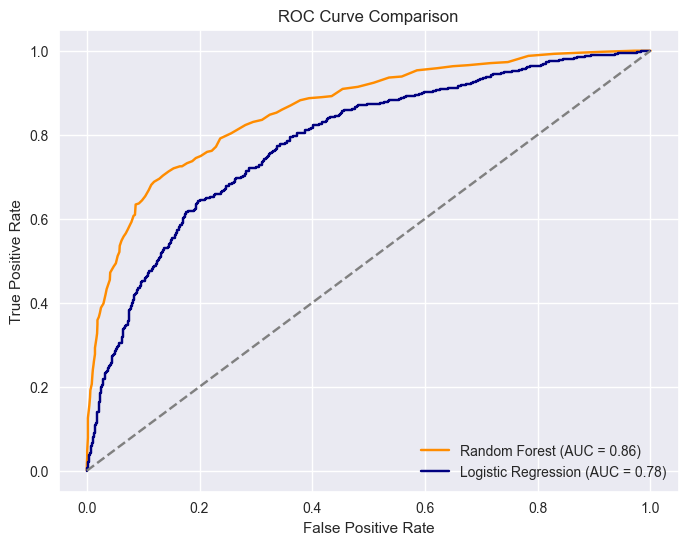

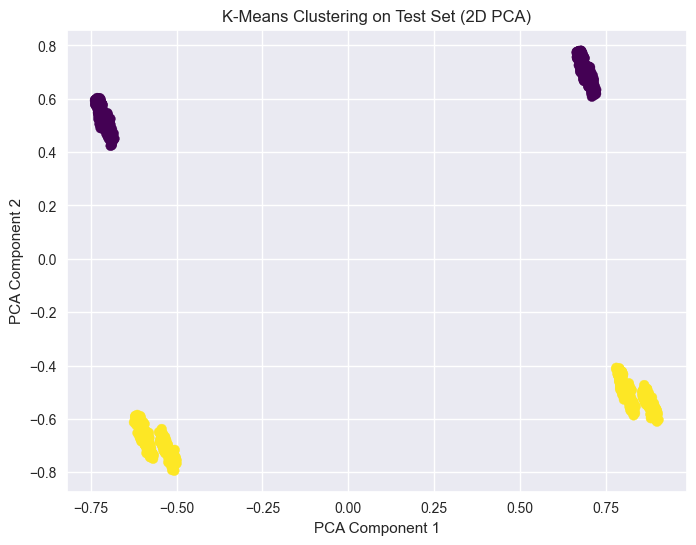

In [24]:
# Random Forest ROC-AUC
rf_probs = rf.predict_proba(X_test_sc)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_rf = roc_auc_score(y_test, rf_probs)

# Logistic Regression ROC-AUC
log_probs = logreg.predict_proba(X_test_sc)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
auc_log = roc_auc_score(y_test, log_probs)

# Combined ROC Curve Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='darkorange')
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})', color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# K-Means Clustering on Test Set
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X_test_sc)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_sc)

# Cluster Visualization
plt.figure(figsize=(8,6))
plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=clusters, cmap='viridis')
plt.title("K-Means Clustering on Test Set (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


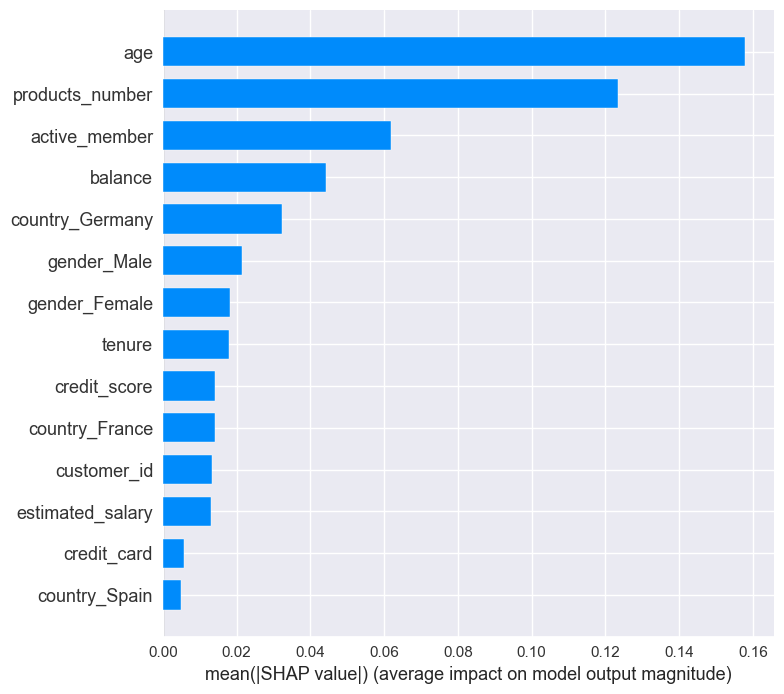

In [25]:
# Use TreeExplainer for tree-based models like RandomForest
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_sc)

# Select SHAP values for class 1 (index 1 on axis 2)
shap_values_class1 = shap_values[:, :, 1]

# Visualize global feature importance for class 1
shap.summary_plot(shap_values_class1, X_test_sc, plot_type="bar")


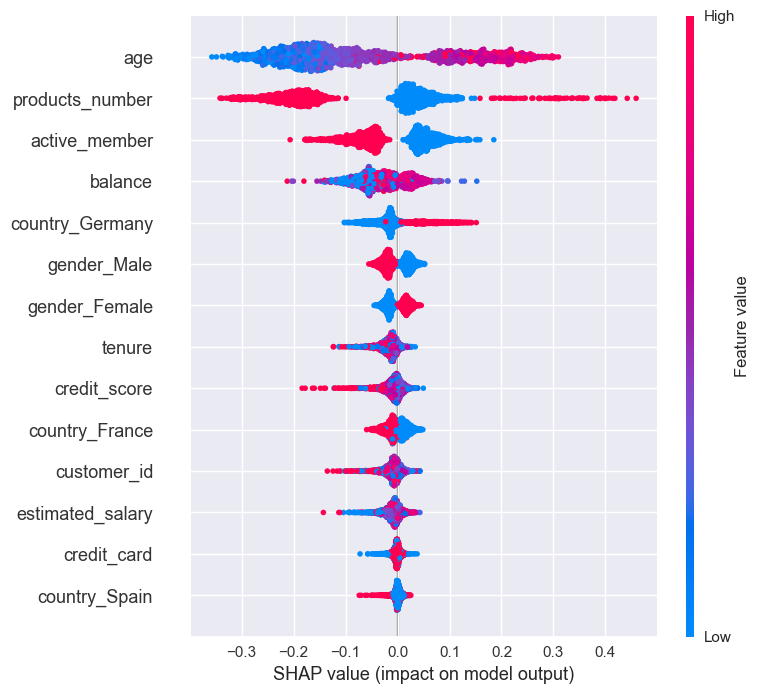

In [26]:
# Use TreeExplainer for tree-based models like RandomForest
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_sc)

# Select SHAP values for class 1
shap_values_class1 = shap_values[:, :, 1]

# Beeswarm plot for class 1 (with feature names, if available)
shap.summary_plot(shap_values_class1, X_test_sc)


In [27]:
from scipy.stats import mode
means = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X_test_sc)

# Step 2: Map KMeans cluster labels to actual labels
# We assume binary classification here (0 and 1)
def map_clusters_to_labels(clusters, true_labels):
    label_map = np.zeros_like(clusters)
    for i in range(2):  # assuming 2 clusters
        mask = (clusters == i)
        label_map[mask] = mode(true_labels[mask])[0]
    return label_map

mapped_clusters = map_clusters_to_labels(clusters, y_test)

# Step 3: Confusion Matrix
cm = confusion_matrix(y_test, mapped_clusters)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1593    0]
 [ 407    0]]


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from scipy.stats import mode
import numpy as np


kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_preds = kmeans.fit_predict(X_test_sc)

# Align KMeans cluster labels with actual class labels
# For each cluster, find the most common true label and map accordingly
def align_clusters(cluster_preds, true_labels):
    labels = np.zeros_like(cluster_preds)
    for cluster in np.unique(cluster_preds):
        mask = cluster_preds == cluster
        labels[mask] = mode(true_labels[mask], keepdims=True).mode[0]
    return labels

aligned_preds = align_clusters(kmeans_preds, y_test.values)

# Evaluate
print("K-Means Clustering Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, aligned_preds))


K-Means Clustering Evaluation
Confusion Matrix:
 [[1593    0]
 [ 407    0]]


In [31]:
# 1. Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

# 2. Assume you have a DataFrame called 'data' and target 'churn'
X = data.drop('churn', axis=1)
y = data['churn']

# 3. Identify categorical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 4. Preprocessing: One-Hot Encode categorical features + Standard Scale numeric features
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), [col for col in X.columns if col not in categorical_features])
])

# 5. Create a pipeline: Preprocessing + Neural Net
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(64,32),
                                 activation='relu',
                                 solver='adam',
                                 max_iter=500,
                                 random_state=0))
])

# 6. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify=y)

# 7. Fit the model
model.fit(X_train, y_train)

# 8. Predict
mlp_preds = model.predict(X_test)

# 9. Evaluate
print("Neural Network (MLPClassifier) Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_preds))
print("\nClassification Report:\n", classification_report(y_test, mlp_preds))


Neural Network (MLPClassifier) Evaluation
Confusion Matrix:
 [[1429  164]
 [ 193  214]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1593
           1       0.57      0.53      0.55       407

    accuracy                           0.82      2000
   macro avg       0.72      0.71      0.72      2000
weighted avg       0.82      0.82      0.82      2000



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

